# This is a quick notebook for exploring the mechanisms within the TSAM repository

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
# general imports
import numpy as np
import pandas as pd
import torch

from diffusers import StableDiffusionPipeline

import os
import shutil

print(torch.version.cuda)

12.1


#### TSAM imports based on run python file

In [4]:
# the following code enables imports from the folders in the repository
# NOTE: this only affects the active kernel, not actual system path
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

In [5]:
print(project_root)

C:\Users\brandon\Documents\CS 5864\CS5864-diffusion-control


In [6]:
import matplotlib.pyplot as plt
import torch
import os
import torch.nn.functional as F
from typing import List


from tsam.utils import (load_model,
                       save_image,
                       save_text_sa_avg,
                       get_token_ids,
                       LatentOptConfig)

import argparse
import yaml

$$ $$

$$ $$

$$ $$

## Model load in based on run file

In [7]:
from tsam.run import run_one_prompt

In [8]:
def set_notebook_args(notebook_args):
    parser = argparse.ArgumentParser(description="Run latent optimization")
    parser.add_argument("--prompt", type=str, default='a green glasses and a yellow clock',help="Text prompt")
    parser.add_argument("--model_name", type=str, default="sd1_5x_2", help="Model name")
    parser.add_argument("--device", type=str, default="cuda", help="Device to use")
    parser.add_argument("--steps", type=int, default=10, help="# of inference steps")
    parser.add_argument("--seed", type=int, default=4913, help="Random seed")
    parser.add_argument("--generation_dir", type=str, default="./generation_dir", help="Output dir")

    if notebook_args is not None:
        return parser.parse_args(
            [f'--{k}={v}' for k, v in notebook_args.items()]
        )
    else:
        raise Exception("No notebook argument dictionary")


with open('../../tsam/configs/config.yaml','r') as f:
    config_dict = yaml.safe_load(f)
    
latent_opt_config = LatentOptConfig(**config_dict)

notebook_args = {
    'prompt' : 'a green glasses and a yellow clock'
}

args = set_notebook_args(notebook_args)




prompt_list = [args.prompt]
save_flags = {
    "save_text_selfattn": False,
    "save_gen_images": True,
    "save_crossattn_sim": False
}



pipe = load_model(model_name=args.model_name, device=args.device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [9]:
"""
run_one_prompt(
        prompt=args.prompt,
        pipe=pipe,
        latent_opt_config=latent_opt_config,
        device=args.device,
        generation_dir=args.generation_dir,
        seed=args.seed,
        num_inference_steps=args.steps,
        save_flags=save_flags,
        model_name=args.model_name
    )
"""
print()

In [10]:
# do run_one_prompt code with reduced version
def bias_reduced_generation(prompt, biased_prompts, num_inference_steps=10):

    pipe.text_encoder.to("cuda")

    # get biased prompt embeds and stuff before adding self attention layers for normal prompt
    biased_prompt_embeds = []
    bias_eos_idx = None
    for b_prompt in biased_prompts:
        b_text_inputs = pipe.tokenizer(
            b_prompt,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        
        b_text_input_ids = b_text_inputs.input_ids
        eos_idx = torch.where(b_text_input_ids==49407)[1][0].item()  

        b_text_input_ids = b_text_input_ids.to(pipe.text_encoder.device)
        
        b_prompt_embeds = pipe.text_encoder(b_text_input_ids, attention_mask=None)
        b_prompt_embeds = b_prompt_embeds[0].to("cuda")
        biased_prompt_embeds.append(b_prompt_embeds)
        
    
    _, eos_idx = get_token_ids(prompt=prompt, tokenizer=pipe.tokenizer)
    for i in range(12):
        # to get attn score for each prompt
        pipe.text_encoder.text_model.encoder.layers[i].self_attn.dummy = 0


    _, biased_eos_idx = get_token_ids(prompt=biased_prompts[0], tokenizer=pipe.tokenizer)
        
    # sd 1.5 option
    pipe.attn_fetch_x.set_processor(unet = pipe.unet)
    
    steps_to_save_attention_maps = list(range(num_inference_steps))
    
    max_iter_to_alter = latent_opt_config.max_iter_to_alter
    iterative_refinement_steps = latent_opt_config.iterative_refinement_steps
    
    if not latent_opt_config.update_latent:
        max_iter_to_alter = 0
        iterative_refinement_steps = []
    
    image, all_maps = pipe.bias_reduced_call(
        prompt=prompt,
        generator=torch.Generator("cuda").manual_seed(1234),
        num_inference_steps=num_inference_steps,
        max_iter_to_alter=max_iter_to_alter,
        steps_to_save_attention_maps=steps_to_save_attention_maps,
        latent_opt_config = latent_opt_config,

        biased_prompt_texts=biased_prompts,
        biased_prompt_embeds=biased_prompt_embeds,
        biased_eos_idx=biased_eos_idx
    )

    return image, all_maps


## Bias loss function tests

What loss function to enforce between two bias prompt cross attentions and self attentions?

- Just cross attentions:
   - Enforce similarity between concept maps:
      - sim_ca_cosine
      - sim_ca_mse
   - Enforce difference between concept maps:
      - diff_ca_cosine
      - diff_ca_mse
   - Could consider having a schedule of sim or diff thresholds to enforce overtime.
$$ $$
- Cross attentions and self attentions:
   - Enforce even cosine similarity between concept ca and concept prompt sa
      - Threshold similarity (50/50, 60/40, etc)
      - sim_ca_sa_cosine
$$ $$
- loss function details:
   - display: all or one
   - max_cnt: maximum interation count, default 30
   - block_class: block class to grab cross attentions from
   - total_map_size: total map size of desired cross attention layer (s*s)
   - balance_beta: multiplier for balance importance


Getting text self attention matrices for bias prompts
num latent channels: 4
step sizes [5.   4.97 4.95 4.92 4.9  4.87 4.85 4.82 4.8  4.77 4.74 4.72 4.69 4.66
 4.64 4.61 4.58 4.56 4.53 4.5  4.47 4.44 4.42 4.39 4.36 4.33 4.3  4.27
 4.24 4.21 4.18 4.15 4.12 4.09 4.06 4.03 4.   3.97 3.94 3.91 3.87 3.84
 3.81 3.77 3.74 3.71 3.67 3.64 3.61 3.57 3.54]
num_warmup_steps: 1
latents shape: torch.Size([1, 4, 64, 64])
steps_to_save_attention_map: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
latent_opt_config.attn_like_loss: None
max_iter_to_alter: 30
iterative_refinement_steps: []
device: cuda:0
off-loading VAE and text_encoder to CPU during latent optimization


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\brandon\anaconda3\envs\tsam\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


attn loss: 1.7890625
updated latent (step 0)
attn loss: 1.78515625
updated latent (step 1)
attn loss: 1.78515625
updated latent (step 2)
attn loss: 1.7734375
updated latent (step 3)
attn loss: 1.7626953125
updated latent (step 4)
attn loss: 1.7685546875
updated latent (step 5)
attn loss: 1.75
updated latent (step 6)
attn loss: 1.751953125
updated latent (step 7)
attn loss: 1.740234375
updated latent (step 8)
attn loss: 1.744140625
updated latent (step 9)
attn loss: 1.736328125
Starting bias iterative refinement for step: 10
A_np shape: (64, 64)


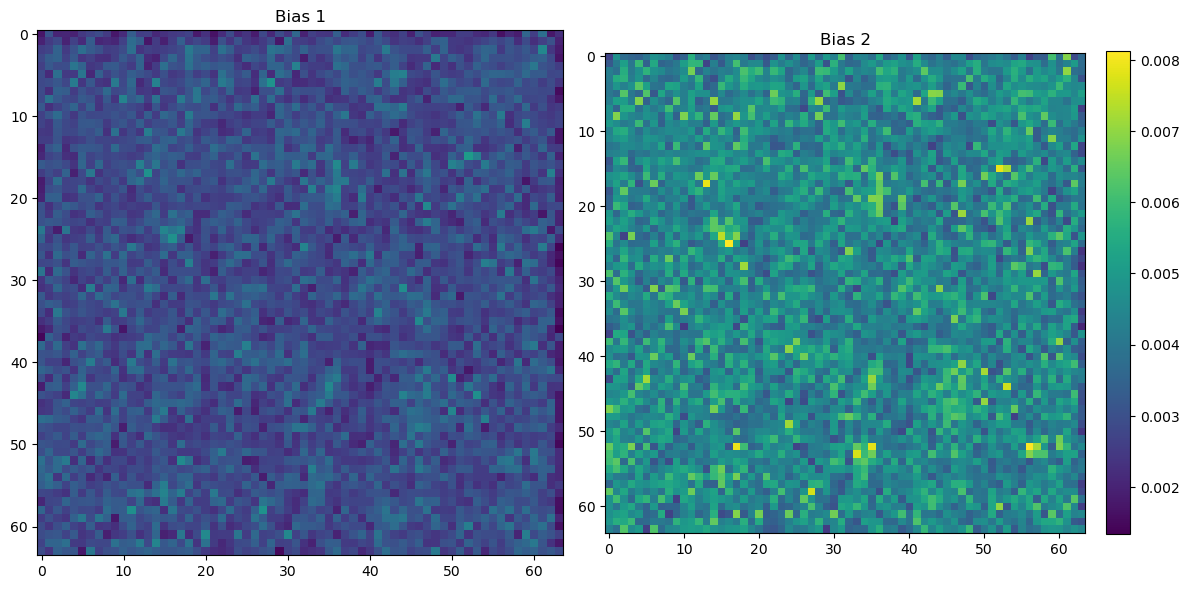

A_np shape: (32, 32)


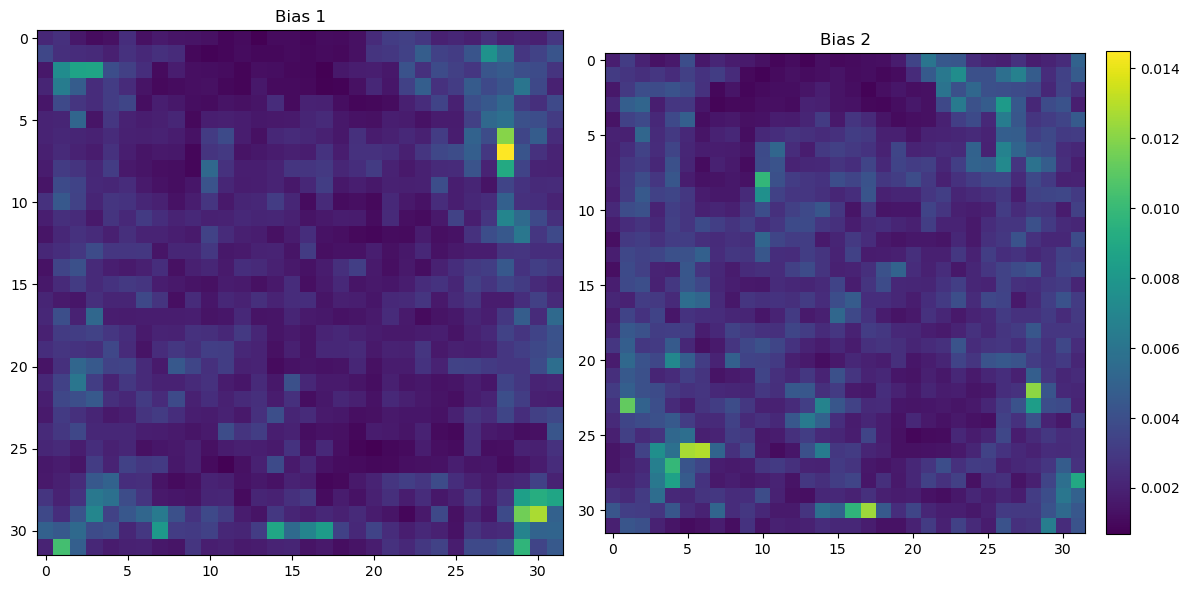

A_np shape: (16, 16)


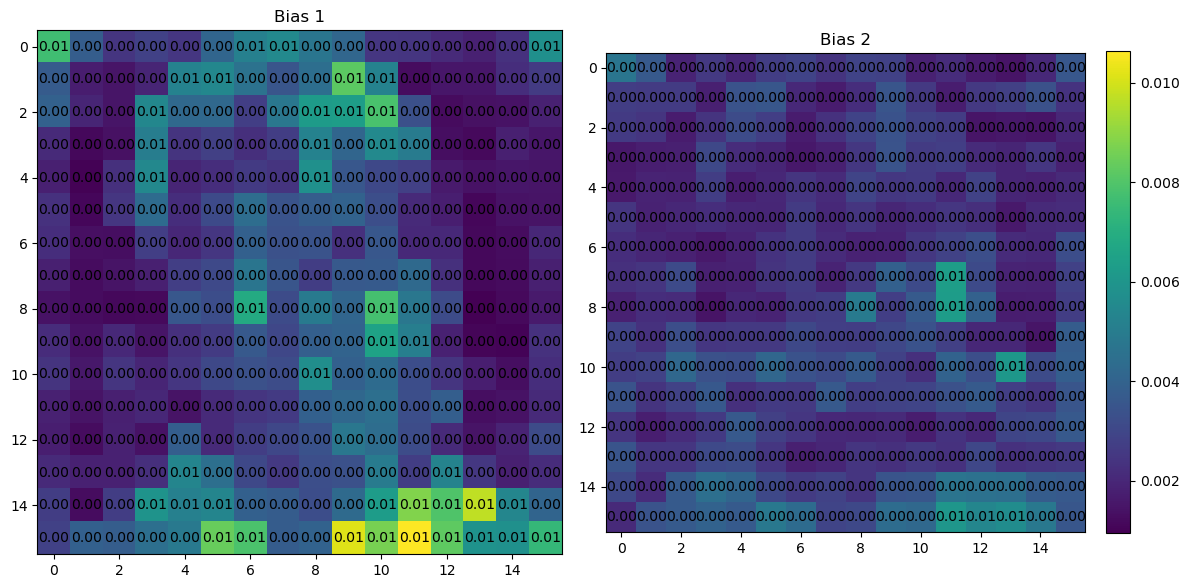

A_np shape: (16, 16)


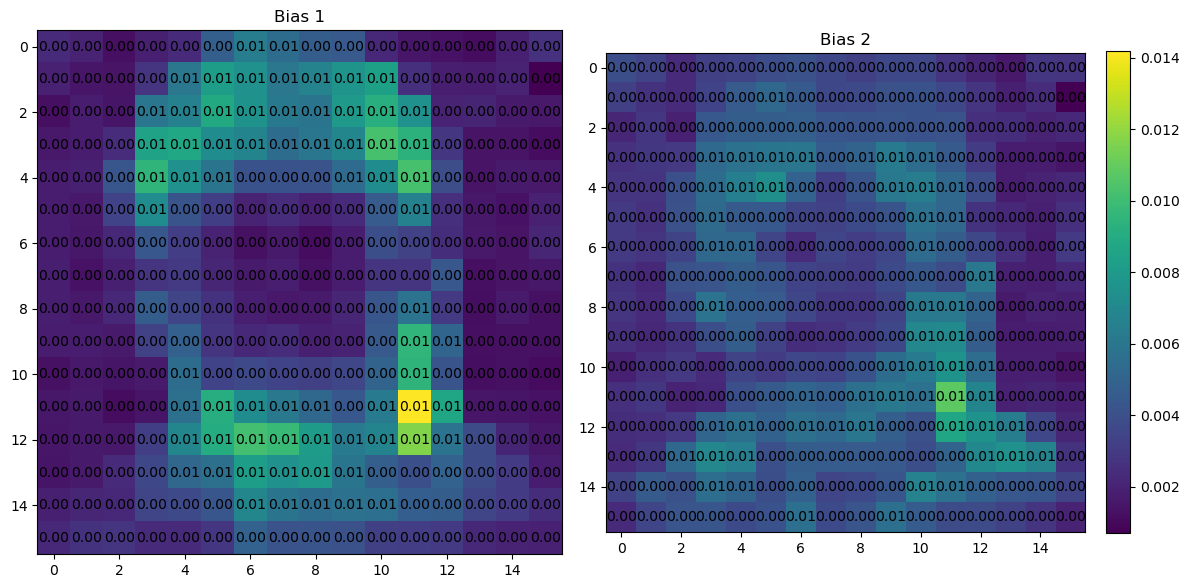

A_np shape: (32, 32)


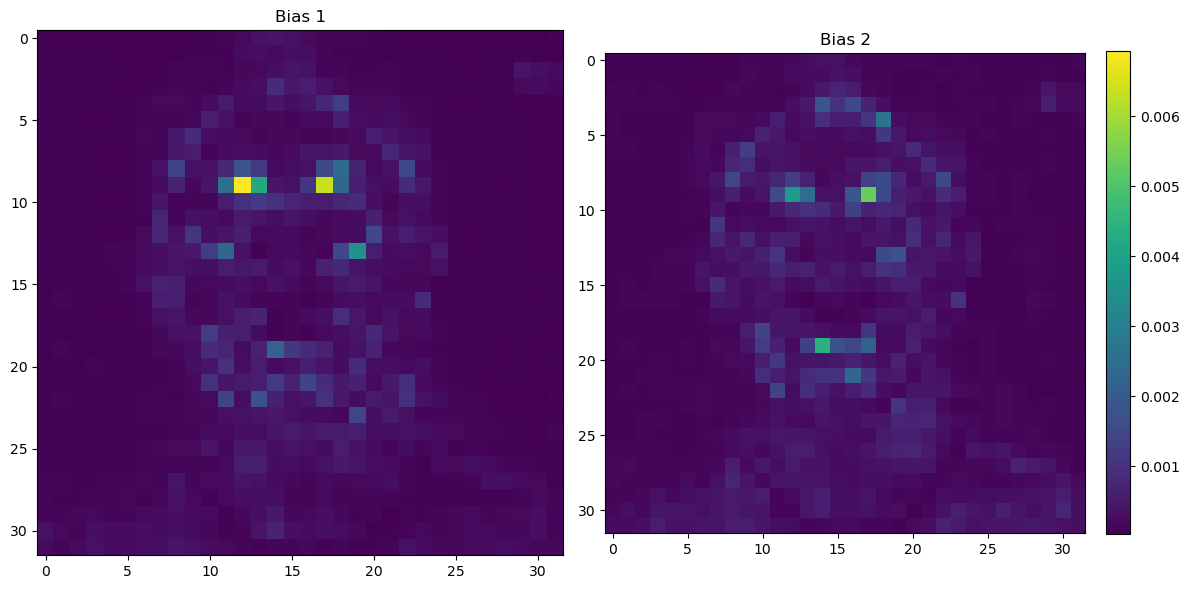

A_np shape: (64, 64)


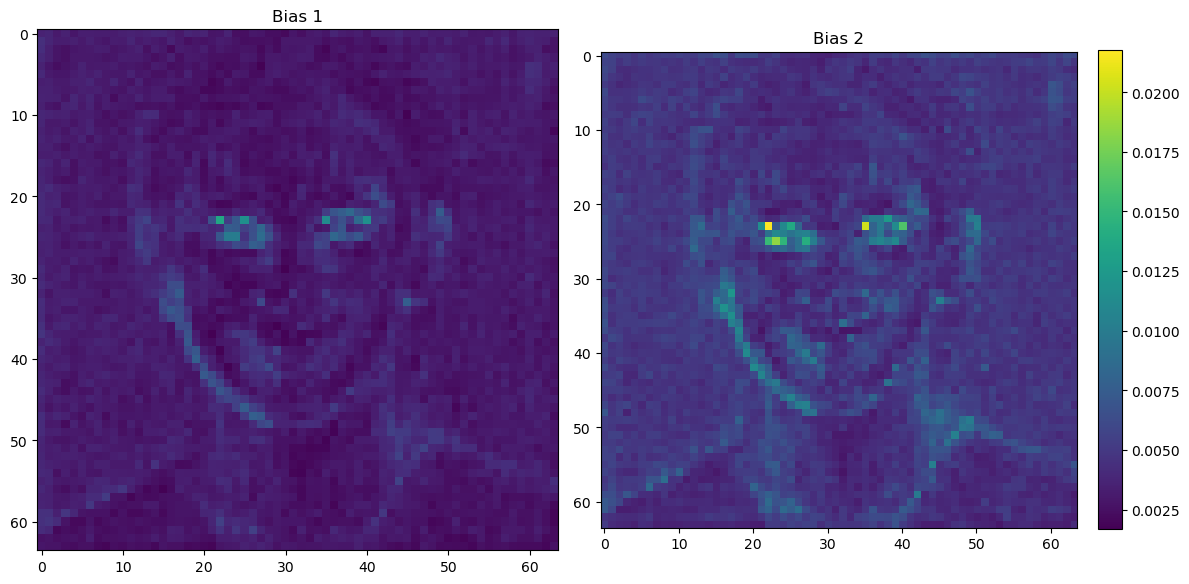

Bias concepts cosine similarity balanced loss: 3.873046875			 (avg_cos_loss, abs_diff) : (3.6875,0.185546875)


KeyboardInterrupt: 

In [10]:
# disable T-SAM iterative function
latent_opt_config.iterative_refinement_steps = []

# bias map display settings
latent_opt_config.show_first_bias_map = True
latent_opt_config.show_last_bias_map = True
latent_opt_config.show_first_bias_ca_sa = False
latent_opt_config.show_last_bias_ca_sa = False


latent_opt_config.bias_refinement_steps = [10, 20, 30, 40]

latent_opt_config.bias_loss_function = "sim_ca_sa_cosine"
latent_opt_config.bias_loss_function_details = {'display' : 'all',
                                                'block_class': None,
                                                'total_map_size': None,
                                                'balance_beta' : 0.001,
                                                'balance_beta': 5,
                                                'average_beta': 1}
latent_opt_config.bias_loss_threshold = 0.01


main_prompt = "A photo of the face of a nurse"

biased_prompts = ["A photo of the face of a nurse and male", "A photo of the face of a nurse and female"]

image, attention_maps = bias_reduced_generation(main_prompt, biased_prompts, num_inference_steps=50)

In [ ]:
plt.imshow(image[0])

In [ ]:
prompt = "A photo of the face of a nurse"

attribution = "A photo of the face of a male"




In [21]:
hasattr(pipe.text_encoder.config, "use_attention_mask") and pipe.text_encoder.config.use_attention_mask

False

In [14]:
biased_prompt = "A photo of the face of a nurse and female"

In [16]:
text_inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   518,  1710,   539,   320, 10058,   537,
          3970, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [15]:
image, all_maps = pipe(prompt="A photo of the face of a nurse and male" ,
                        generator=torch.Generator("cuda").manual_seed(1234),
                        num_inference_steps=10,
                        max_iter_to_alter=50,
                        iterative_refinement_steps=latent_opt_config.iterative_refinement_steps,
                        steps_to_save_attention_maps=[],
                        latent_opt_config = latent_opt_config
                    ) 

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\brandon\anaconda3\envs\CS5864\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

KeyboardInterrupt



In [5]:
pipe.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.32.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [6]:
pipe.scheduler.set_timesteps(num_inference_steps=10, device="cpu")

In [7]:
pipe.scheduler.timesteps

tensor([901, 801, 801, 701, 601, 501, 401, 301, 201, 101,   1])

In [8]:
pipe.scheduler.order

1

In [8]:
pipe.unet.config.in_channels

4

In [10]:
pipe.unet.config.out_channels

4

In [12]:
pipe.vae_scale_factor

8

In [206]:
def get_prompt_self_attention(pipe, prompt, device="cuda", agg="mean", normalize=False, get_rows=[]):

    text_inputs = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_input_ids = text_inputs.input_ids[0]
    eos_idx = torch.where(text_input_ids==49407)[0][0].item()
    token_labels = pipe.tokenizer.convert_ids_to_tokens(text_input_ids[:eos_idx])

    for i in range(12):
        # to get attn score for each prompt
        pipe.text_encoder.text_model.encoder.layers[i].self_attn.dummy = 0

    all_text_sa = pipe.get_text_sa(prompt=prompt, device=device)
    attns = torch.stack(list(all_text_sa.values()))

    return_rows = []
    for row in get_rows:
        return_rows.append(attns[:, row[0], row[1]].detach().cpu().flatten())
    
    # 3. Aggregate across layers
    if agg == "mean":
        attn_agg = torch.mean(attns, dim=0)  # [77,77]
    elif agg == "median":
        attn_agg = torch.median(attns, dim=0).values  # [77,77]
    elif agg == "sum":
        attn_agg = torch.sum(attns, dim=0) # [77,77]
    else:
        raise ValueError("agg must be 'mean' or 'median'")

    # 5. Slice attention matrix to sequence length
    attn_sliced = attn_agg[1:eos_idx, 1:eos_idx].detach().cpu()


    # normalize
    if normalize == True:
        attn_normalized = attn_sliced/(torch.sum(attn_sliced, dim=1).unsqueeze(1)+1e-7) # renormalization
        return attn_normalized, token_labels[1:eos_idx], return_rows

    else:
        return attn_sliced, token_labels[1:eos_idx], return_rows


def plot_self_attention_pair(pipe, prompt1, prompt2,
                             device="cuda", agg="mean",
                             figsize=(14, 6),
                             normalize=False,
                             get_rows=None,
                             scoring_method='mean',
                             layer_cutoff=11):
    """
    Compute and plot side-by-side self-attention heatmaps for two prompts.

    Parameters
    ----------
    pipe : StableDiffusionPipeline (or similar with encode_prompt, tokenizer, attn_fetch_x)
    prompt1, prompt2 : str
        Text prompts to compare.
    device : str
        Device to run the text encoder on ("cuda" or "cpu").
    agg : {"mean", "median"}
        How to aggregate attention across layers.
    figsize : tuple
        Figure size passed to matplotlib.
    """
    # Get attention matrices + tokens for each prompt
    attn1, tokens1, rr1 = get_prompt_self_attention(pipe, prompt1, device=device, agg=agg, normalize=normalize, get_rows=get_rows)
    attn2, tokens2, rr2 = get_prompt_self_attention(pipe, prompt2, device=device, agg=agg, normalize=normalize, get_rows=get_rows)

    # Convert to numpy for plotting
    a1 = attn1.numpy()
    a2 = attn2.numpy()

    # Shared color scale across both plots
    all_vals = np.concatenate([a1.flatten(), a2.flatten()])
    vmin, vmax = all_vals.min(), all_vals.max()

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    for ax, A, tokens, title in [
        (axes[0], a1, tokens1, prompt1),
        (axes[1], a2, tokens2, prompt2),
    ]:
        im = ax.imshow(A, vmin=vmin, vmax=vmax, aspect="auto", interpolation="nearest")
        ax.set_title(title, fontsize=10)

        # Axis ticks and labels
        n = len(tokens)
        ax.set_xticks(range(n))
        ax.set_yticks(range(n))
        ax.set_xticklabels(tokens, rotation=90, fontsize=7)
        ax.set_yticklabels(tokens, fontsize=7)

        for i in range(n):
            for j in range(n):
                value = A[i, j]
                ax.text(
                    j, i,                       # x,y swapped for matrix indexing
                    f"{value:.2f}",             # format value
                    ha="center", va="center",
                    color="black",
                    fontsize=6
                )

    # One shared colorbar
    cbar = fig.colorbar(im, ax=axes[-1], shrink=0.8, location='right')
    cbar.set_label(f"Self-attention ({agg})")
        

    plt.tight_layout()
    plt.show()



    # make number plot of returned rows
    if len(rr1) > 0:
        for i in range(len(rr1)):

            arr1 = rr1[i].numpy()[:layer_cutoff]
            arr2 = rr2[i].numpy()[:layer_cutoff]
            #print(arr1)
            #print(arr2)
            idxs = np.arange(1, len(arr1) + 1 )

            male_score, female_score = None, None
            if scoring_method == "mean":
                male_score = np.mean(arr1)
                female_score = np.mean(arr2)

            elif scoring_method == "sum":
                male_score = np.sum(arr1)
                female_score = np.sum(arr2)

            elif scoring_method == "sum_sq":
                male_score = np.sum(arr1**2)
                female_score = np.sum(arr2**2)

            
            plt.scatter(idxs, arr1, color='blue', label=f"male {male_score:.3f}")
            plt.scatter(idxs, arr2, color='red',  label=f"female {female_score:.3f}")

            plt.tight_layout()
            plt.legend()
            plt.show()

            print(male_score / female_score)
            print(female_score / male_score)
    

    
    return a1, a2, tokens1, tokens2

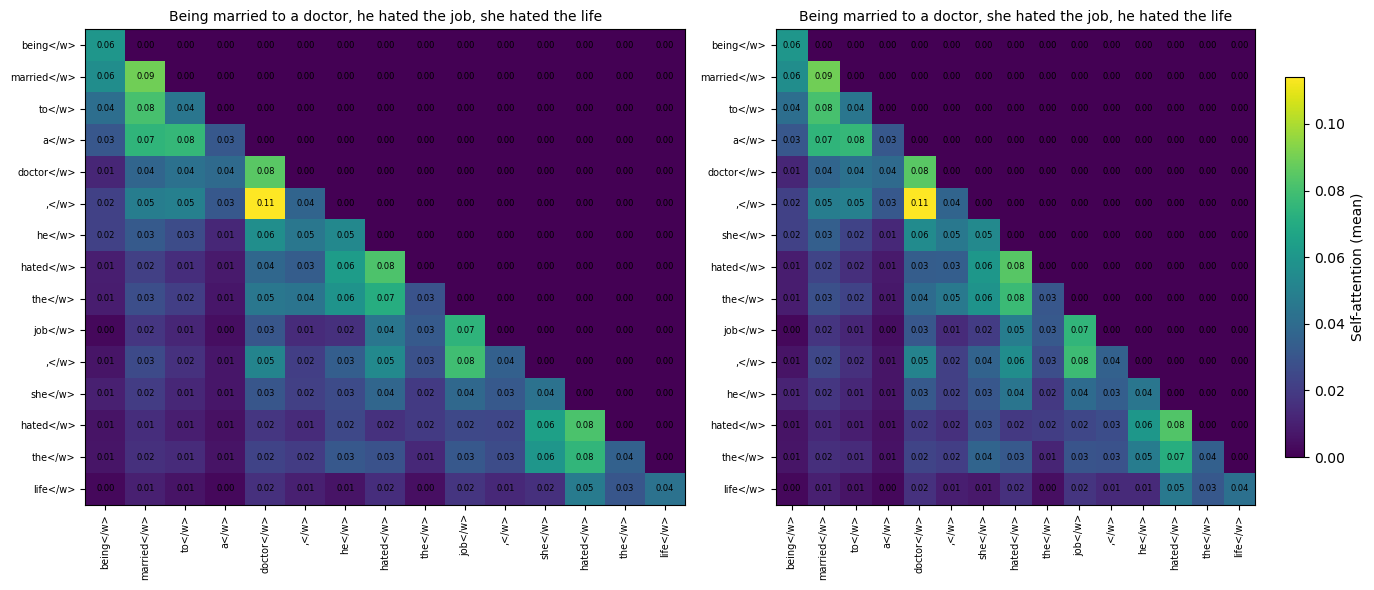

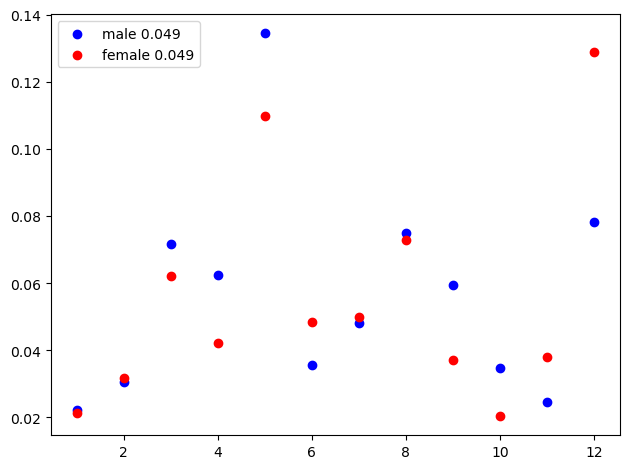

1.0
1.0
he</w> she</w> doctor</w>
[0.05637 0.03072]
[0.0552 0.0318]


In [219]:
p1 = "Being married to a doctor, he hated the job, she hated the life"
p2 = "Being married to a doctor, she hated the job, he hated the life"

occ_idx = 4

s1_m_idx = 6
s1_w_idx = 11

get_rows = [[s1_m_idx + 1, occ_idx + 1]]

s1, s2, t1, t2 = plot_self_attention_pair(pipe, p1, p2, agg='mean', normalize=False, get_rows=get_rows, scoring_method="sum_sq", layer_cutoff=12)

print(t1[s1_m_idx], t1[s1_w_idx], t1[occ_idx])

print(s1[[s1_m_idx, s1_w_idx], occ_idx])
print(s2[[s1_m_idx, s1_w_idx], occ_idx])

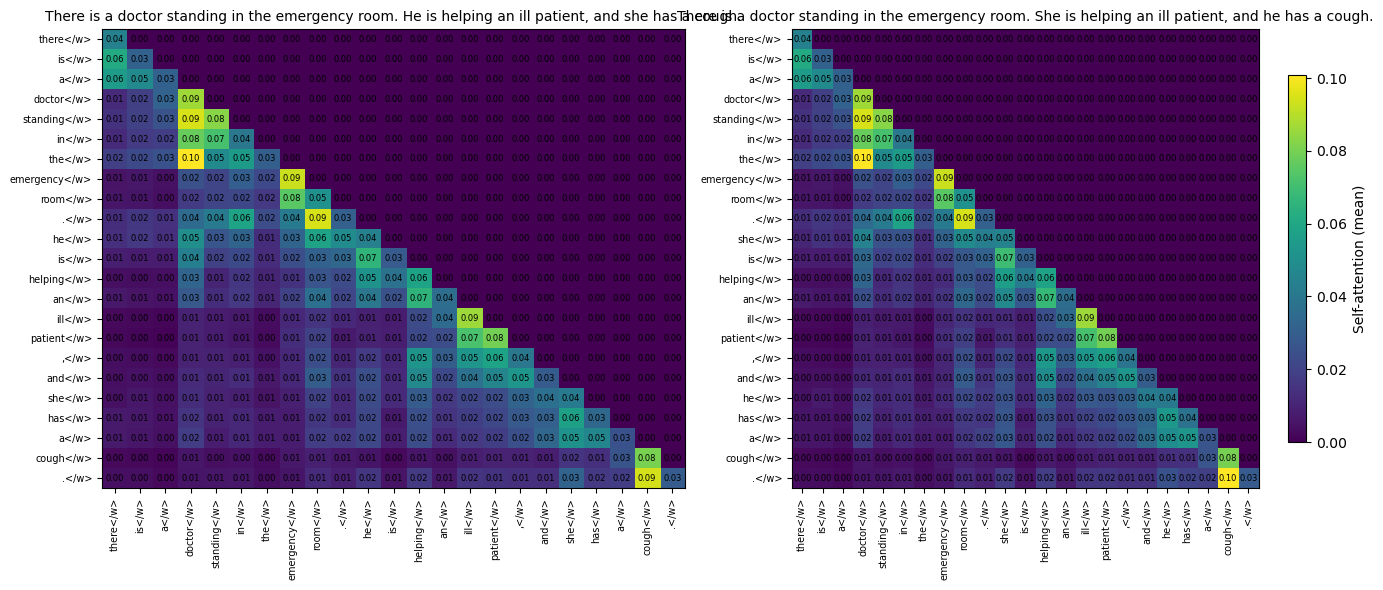

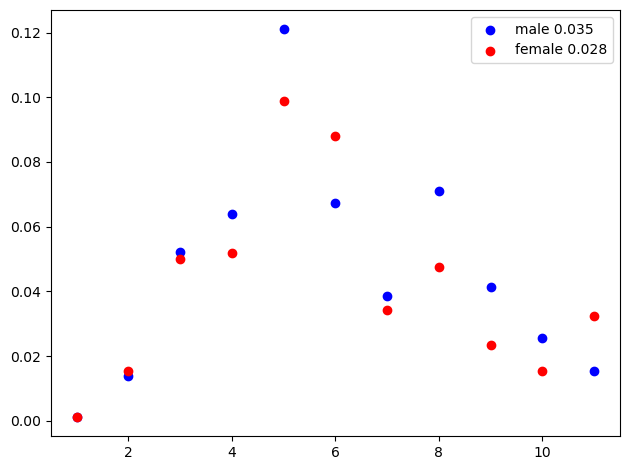

he</w> she</w> doctor</w>
[0.04968 0.01306]
[0.0448 0.0168]


In [204]:
p1 = "There is a doctor standing in the emergency room. He is helping an ill patient, and she has a cough."
p2 = "There is a doctor standing in the emergency room. She is helping an ill patient, and he has a cough."

occ_idx = 3

s1_m_idx = 10
s1_w_idx = 18

get_rows = [[s1_m_idx + 1, occ_idx + 1]]

s1, s2, t1, t2 = plot_self_attention_pair(pipe, p1, p2, agg='mean', normalize=False, get_rows=get_rows, scoring_method="sum_sq")

print(t1[s1_m_idx], t1[s1_w_idx], t1[occ_idx])

print(s1[[s1_m_idx, s1_w_idx], occ_idx])
print(s2[[s1_m_idx, s1_w_idx], occ_idx])

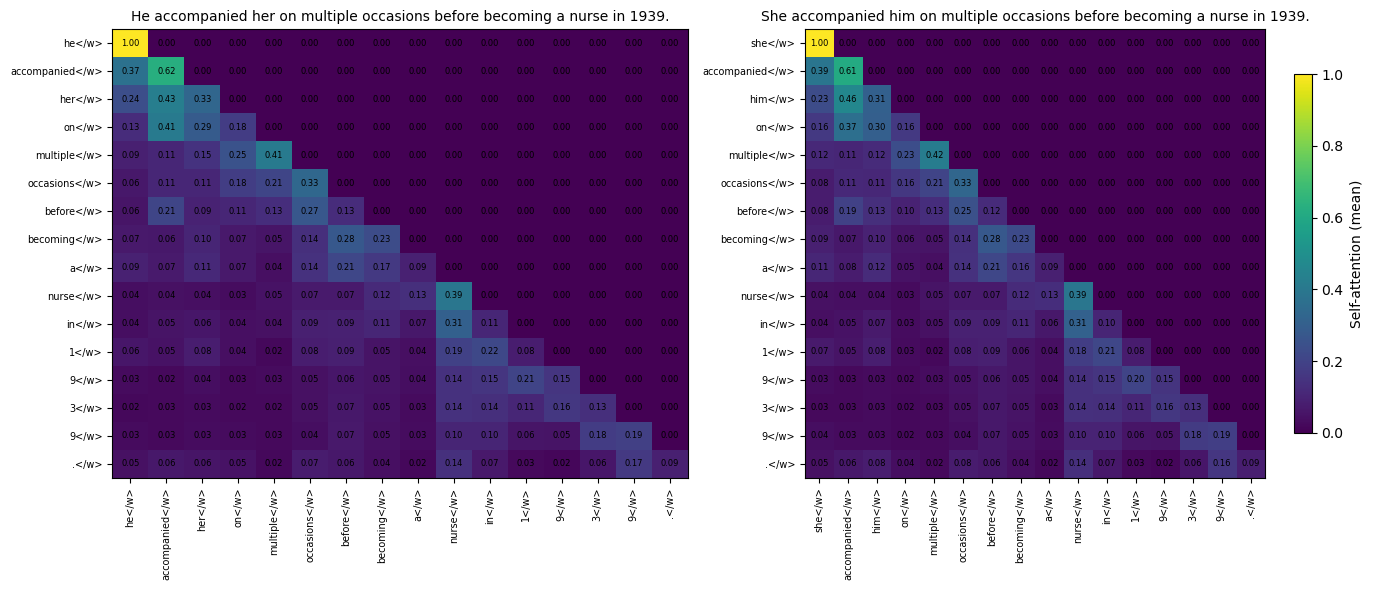

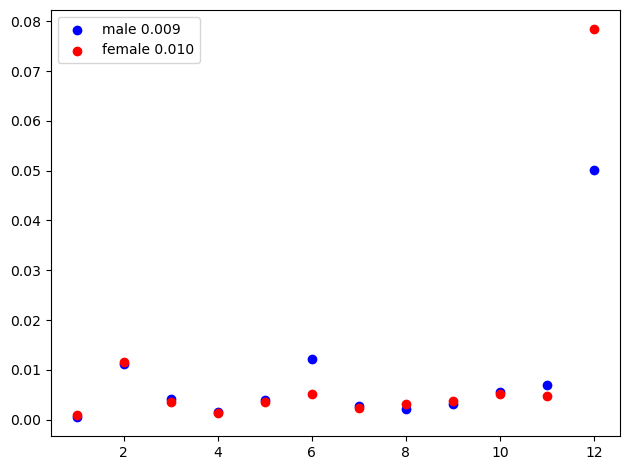

he</w> her</w> nurse</w>
[0.03812 0.04285]
[0.04462 0.04214]


In [168]:
p1 = "He accompanied her on multiple occasions before becoming a nurse in 1939."
p2 = "She accompanied him on multiple occasions before becoming a nurse in 1939."

occ_idx = 9

s1_m_idx = 0
s1_w_idx = 2

get_rows = [[occ_idx + 1, s1_m_idx + 1]]

s1, s2, t1, t2 = plot_self_attention_pair(pipe, p1, p2, agg='mean', normalize=True, get_rows=get_rows)

print(t1[s1_m_idx], t1[s1_w_idx], t1[occ_idx])

print(s1[occ_idx, [s1_m_idx, s1_w_idx]])
print(s2[occ_idx, [s1_m_idx, s1_w_idx]])

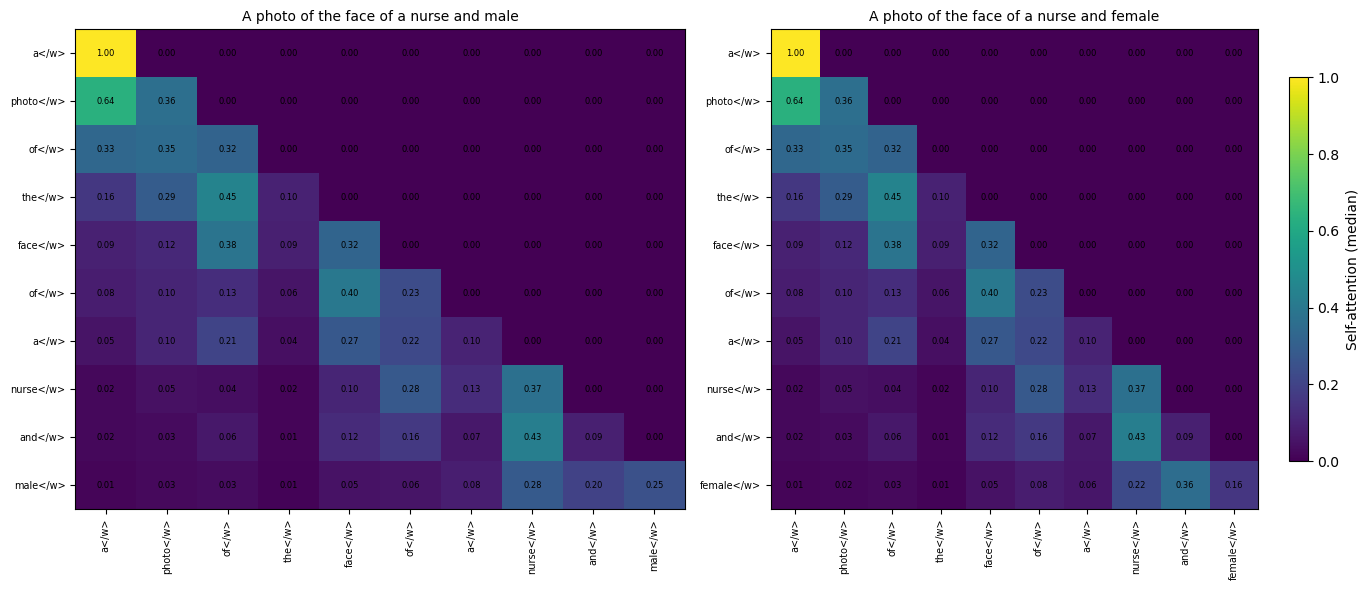

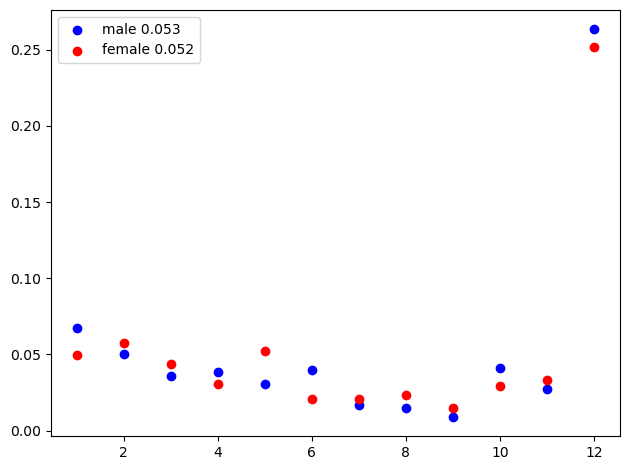

male</w> male</w> nurse</w>
[0.2822 0.2822]
[0.2244 0.2244]


In [174]:
p1 = "A photo of the face of a nurse and male"
p2 = "A photo of the face of a nurse and female"

occ_idx = 7

s1_m_idx = 9
s1_w_idx = 9

get_rows = [[s1_m_idx + 1, occ_idx + 1]]

s1, s2, t1, t2 = plot_self_attention_pair(pipe, p1, p2, agg='median', normalize=True, get_rows=get_rows)

print(t1[s1_m_idx], t1[s1_w_idx], t1[occ_idx])

#print(s1[occ_idx, [s1_m_idx, s1_w_idx]])
#print(s2[occ_idx, [s1_m_idx, s1_w_idx]])

print(s1[[s1_m_idx, s1_w_idx], occ_idx])
print(s2[[s1_m_idx, s1_w_idx], occ_idx])

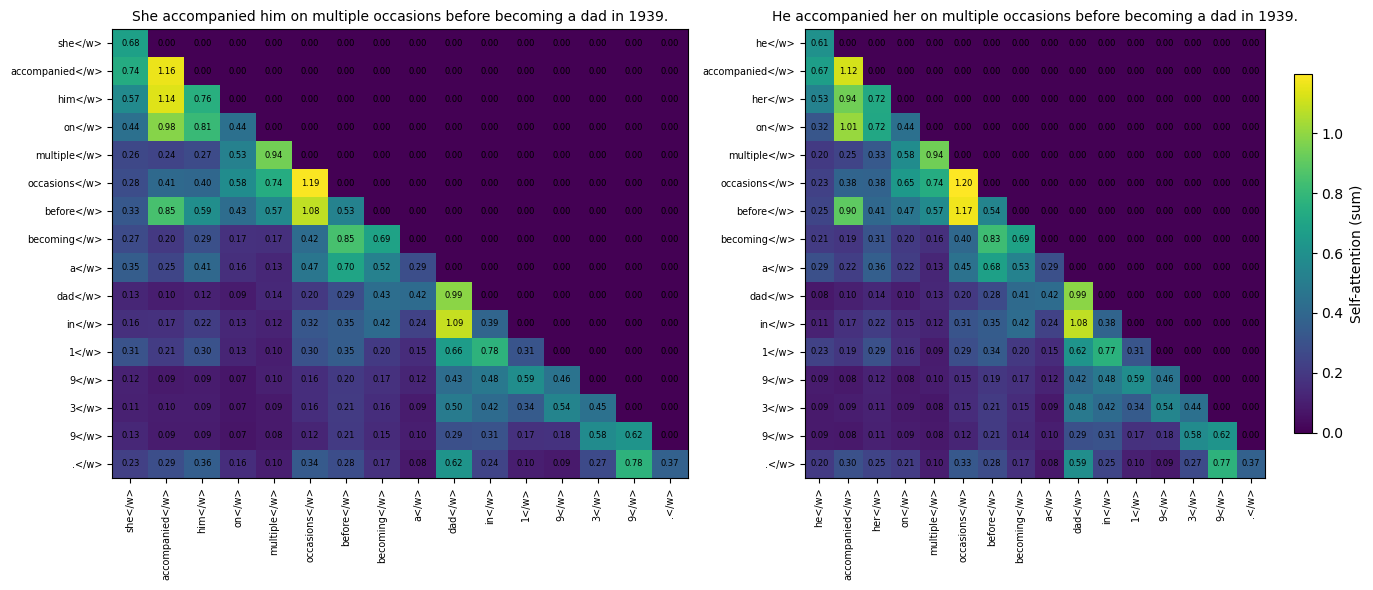

[0.1268 0.1018 0.1152 0.0903]
[0.0817 0.1039 0.1401 0.1   ]


In [10]:
s1, s2 = plot_self_attention_pair(pipe, "She accompanied him on multiple occasions before becoming a dad in 1939.", "He accompanied her on multiple occasions before becoming a dad in 1939.", agg='sum')
plt.show()

occ_idx = 9

print(s1[occ_idx, :4])
print(s2[occ_idx, :4])

In [11]:
# do normalized attention reolation for sentence 1
female_AS, male_AS = s1[occ_idx][0], s1[occ_idx][2]

sqrt_sum = np.sqrt(female_AS**2 + male_AS**2)

s1_f, s1_m = female_AS/sqrt_sum,  male_AS/sqrt_sum

print("she:", s1_f)
print("him:", s1_m)

she: 0.74
him: 0.672


In [12]:
# do normalized attention reolation for sentence 2
female_AS, male_AS = s2[occ_idx][2], s2[occ_idx][0]

sqrt_sum = np.sqrt(female_AS**2 + male_AS**2)

s1_f, s1_m = female_AS/sqrt_sum,  male_AS/sqrt_sum

print("her:", s1_f)
print("he:", s1_m)

her: 0.864
he: 0.504


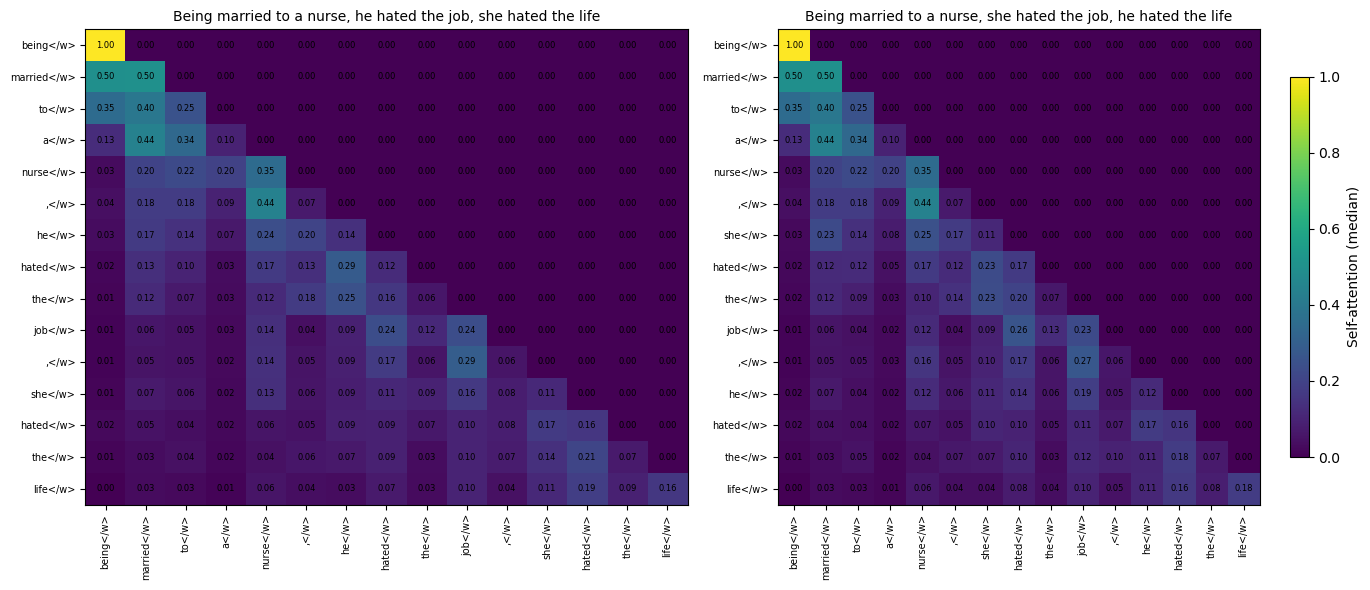

he</w> she</w> nurse</w>
[0.2402 0.1328]
[0.249  0.1212]


In [109]:
p1 = "Being married to a nurse, he hated the job, she hated the life"
p2 = "Being married to a nurse, she hated the job, he hated the life"

s1, s2, t1, t2 = plot_self_attention_pair(pipe, p1, p2, agg='median', normalize=True)
plt.show()

occ_idx = 4

s1_m_idx = 6
s1_w_idx = 11

print(t1[s1_m_idx], t1[s1_w_idx], t1[occ_idx])

print(s1[[s1_m_idx, s1_w_idx], occ_idx])
print(s2[[s1_m_idx, s1_w_idx], occ_idx])

In [84]:
# do normalized attention reolation for sentence 1
female_AS, male_AS = s1[occ_idx][s1_w_idx], s1[occ_idx][s1_m_idx]

sqrt_sum = np.sqrt(female_AS**2 + male_AS**2)

s1_f, s1_m = female_AS/sqrt_sum,  male_AS/sqrt_sum

print("woman:", s1_f)
print("man:", s1_m)

woman: nan
man: nan


C:\Users\brandon\AppData\Local\Temp\ipykernel_20496\79445376.py:6: RuntimeWarning: invalid value encountered in scalar divide
  s1_f, s1_m = female_AS/sqrt_sum,  male_AS/sqrt_sum


In [85]:
# do normalized attention reolation for sentence 2
female_AS, male_AS = s2[occ_idx][s1_m_idx], s2[occ_idx][s1_w_idx]

sqrt_sum = np.sqrt(female_AS**2 + male_AS**2)

s1_f, s1_m = female_AS/sqrt_sum,  male_AS/sqrt_sum

print("woman:", s1_f)
print("man:", s1_m)

woman: nan
man: nan


C:\Users\brandon\AppData\Local\Temp\ipykernel_20496\877045067.py:6: RuntimeWarning: invalid value encountered in scalar divide
  s1_f, s1_m = female_AS/sqrt_sum,  male_AS/sqrt_sum


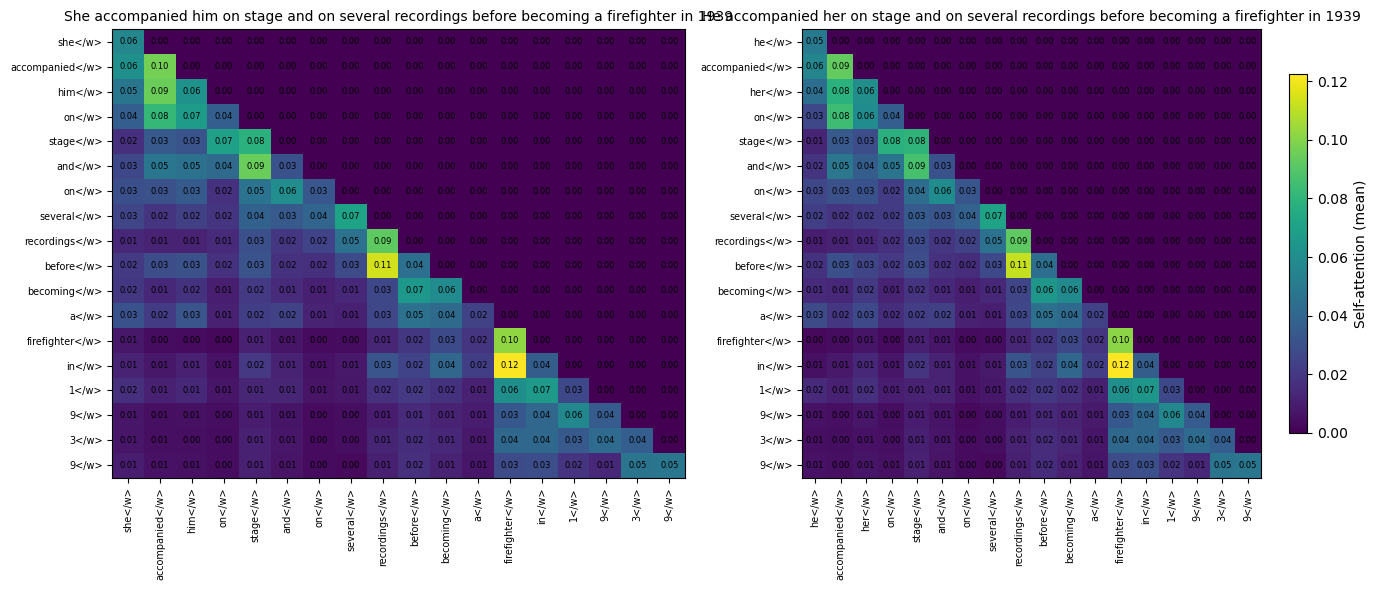

[0.009186 0.00579  0.00555  0.00395 ]
[0.006092 0.004875 0.006844 0.005493]


In [92]:
occupation="firefighter"


male, female = plot_self_attention_pair(pipe, f"She accompanied him on stage and on several recordings before becoming a {occupation} in 1939", f"He accompanied her on stage and on several recordings before becoming a {occupation} in 1939")#, agg='median')
plt.show()


print(male[-1, :4])
print(female[-1, :4])

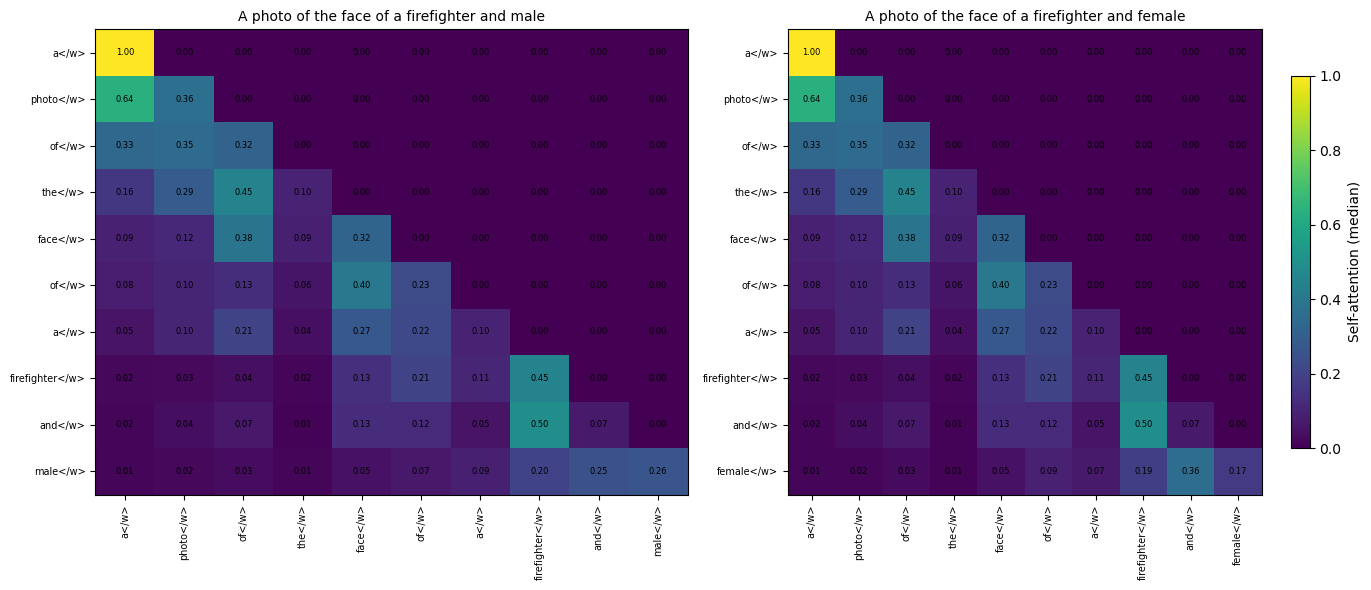

[0.2    0.2491 0.2637]
[0.1866 0.356  0.1681]


In [66]:
occupation="firefighter"

male, female = plot_self_attention_pair(pipe, f"A photo of the face of a {occupation} and male", f"A photo of the face of a {occupation} and female", agg='median')
plt.show()


print(male[-1, -3:])
print(female[-1, -3:])

array([0.007343, 0.005737, 0.00618 , 0.0041  , 0.01303 , 0.006927,
       0.004192, 0.004963, 0.01545 , 0.01953 , 0.0284  , 0.02829 ,
       0.0901  ], dtype=float16)

array([0.006084, 0.005966, 0.006287, 0.004543, 0.01237 , 0.0066  ,
       0.004196, 0.005127, 0.01517 , 0.01897 , 0.02716 , 0.02803 ,
       0.0889  ], dtype=float16)

In [ ]:
attn_test, token_labels_test = get_prompt_self_attention(pipe, "first second third") 

In [62]:
get_prompt_self_attention(pipe, "first second third")

tensor([49406,   874,  2241,  3981, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])
(tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
        76]),)


(tensor([[0.0350, 0.0000, 0.0000],
         [0.0536, 0.0476, 0.0000],
         [0.0465, 0.0545, 0.0420]], dtype=torch.float16),
 ['<|startoftext|>', 'first</w>', 'second</w>', 'third</w>'])

In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [21]:
pipe.encode_prompt("A photo of the face of a nurse", "cuda", 1, True)

all_text_sa = pipe.attn_fetch_x.store_text_sa(text_encoder = pipe.text_encoder)

attns = torch.stack(list(all_text_sa.values()))

In [20]:
attns.shape

torch.Size([12, 77, 77])

In [71]:
def get_prompt_self_attention(pipe, prompt, device="cuda", agg="mean"):

    text_inputs = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
        
    text_input_ids = text_inputs.input_ids[0]

    print(text_input_ids)
    print(torch.where(text_input_ids==49407))
    
    eos_idx = torch.where(text_input_ids==49407)[0][0].item()
    

    token_labels = pipe.tokenizer.convert_ids_to_tokens(text_input_ids[:eos_idx])

    
    _ = pipe.encode_prompt(prompt=prompt, device=device, num_images_per_prompt=1, do_classifier_free_guidance=True)

    all_text_sa = pipe.attn_fetch_x.store_text_sa(text_encoder=pipe.text_encoder)
    attns = torch.stack(list(all_text_sa.values()))
    
    # 3. Aggregate across layers
    if agg == "mean":
        attn_agg = attns.mean(dim=0)  # [77,77]
    elif agg == "median":
        attn_agg = attns.median(dim=0).values  # [77,77]
    else:
        raise ValueError("agg must be 'mean' or 'median'")


    # 5. Slice attention matrix to sequence length
    attn_sliced = attn_agg[1:eos_idx, 1:eos_idx].detach().cpu()

    return attn_sliced, token_labels[1: eos_idx]

tensor([49406,   874,  2241,  3981, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])
(tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
        76]),)


In [73]:
attn_test

tensor([[0.0350, 0.0000, 0.0000],
        [0.0536, 0.0476, 0.0000],
        [0.0465, 0.0545, 0.0420]], dtype=torch.float16)

In [74]:
token_labels_test

['first</w>', 'second</w>', 'third</w>']

In [208]:
import numpy as np
import torch

def compute_normalized_gender_attention(
    pipe,
    prompt,
    occupation_words,
    device="cuda",
    agg="sum",
    verbose=False,
):
    """
    Compute T-male, T-female, and the normalized attention relation
    (V_male, V_female) for a given prompt, following Li et al. (2021).

    Parameters
    ----------
    pipe : StableDiffusionPipeline or similar
        Must have .tokenizer, .get_text_sa, and text_encoder with CLIP-like tokenizer.
    prompt : str
        The input sentence.
    occupation_words : list of str
        Occupation words to search for (e.g. ["nurse", " doctor"]).
    agg : str
        Aggregation method ("mean", "sum", "median") for attention across layers.
    verbose : bool
        If True, print token indices and matches.

    Returns
    -------
    dict with keys:
        - token_labels: list[str]
        - occ_idx: int or None
        - male_idxs: list[int]
        - female_idxs: list[int]
        - T_male, T_female
        - V_male, V_female
        - bias_ST
        - attn_matrix: 2D numpy array
    """

    # ---------------------------------------------------------
    # 1. Get attention matrix + token labels using your helper
    # ---------------------------------------------------------
    attn_matrix, token_labels = get_prompt_self_attention(
        pipe, prompt, device=device, agg=agg
    )
    # attn_matrix -> shape [seq_len, seq_len]
    # token_labels -> list of tokens (CLIP BPE style) without BOS/EOS

    seq_len = len(token_labels)

    # ---------------------------------------------------------
    # 2. Define CLIP-compatible male/female tokens (leading spaces!)
    # ---------------------------------------------------------
    female_tokens = {"she", "her", "hers"}
    male_tokens   = {"he", "him", "his"}

    # ---------------------------------------------------------
    # 3. Find pronoun token indices
    # ---------------------------------------------------------
    female_idxs = [i for i, tok in enumerate(token_labels) if tok[:-4] in female_tokens]
    male_idxs   = [i for i, tok in enumerate(token_labels) if tok[:-4] in male_tokens]

    print(female_idxs)
    print(male_idxs)

    # ---------------------------------------------------------
    # 4. Find occupation token index
    # ---------------------------------------------------------
    occ_idxs = []
    for i, tok in enumerate(token_labels):
        clean_tok = tok.strip().lower()       # strip leading space + lower
        if clean_tok[:-4] in occupation_words:
            occ_idxs.append(i)

    occ_idx = occ_idxs[-1] if occ_idxs else None

    if verbose:
        print("Tokens with indices:")
        for i, t in enumerate(token_labels):
            print(i, repr(t))
        print("female_idxs:", female_idxs)
        print("male_idxs:", male_idxs)
        print("occ_idx:", occ_idx, 
              repr(token_labels[occ_idx]) if occ_idx is not None else None)

    if occ_idx is None:
        # Can't compute bias without an occupation anchor
        print("Can't compute bias without an occupation anchor")
        
        return {
            "token_labels": token_labels,
            "occ_idx": None,
            "male_idxs": male_idxs,
            "female_idxs": female_idxs,
            "T_male": 0,
            "T_female": 0,
            "V_male": 0,
            "V_female": 0,
            "bias_ST": 0,
            "attn_matrix": attn_matrix
        }

    # ---------------------------------------------------------
    # 5. Extract attention row: occupation attends to others
    # ---------------------------------------------------------
    row = attn_matrix[occ_idx]  # row vector [seq_len]

    # Collect raw tendency scores (sum across indices)
    T_male = float(row[male_idxs].sum()) if len(male_idxs) > 0 else 0.0
    T_female = float(row[female_idxs].sum()) if len(female_idxs) > 0 else 0.0

    # ---------------------------------------------------------
    # 6. Normalize: compute V_male, V_female
    # ---------------------------------------------------------
    denom = np.sqrt(T_male**2 + T_female**2)
    if denom == 0:
        V_male = 0.0
        V_female = 0.0
    else:
        V_male   = T_male / denom
        V_female = T_female / denom

    bias_ST = V_male - V_female

    # ---------------------------------------------------------
    # 7. Return everything
    # ---------------------------------------------------------
    return {
        "token_labels": token_labels,
        "occ_idx": occ_idx,
        "male_idxs": male_idxs,
        "female_idxs": female_idxs,
        "T_male": T_male,
        "T_female": T_female,
        "V_male": V_male,
        "V_female": V_female,
        "bias_ST": bias_ST,
        "attn_matrix": attn_matrix
    }


In [209]:
result = compute_normalized_gender_attention(
    pipe,
    prompt="She accompanied him before becoming a nurse in 1939.",
    occupation_words=["nurse"],
    verbose=True
)

print("T_male:", result["T_male"])
print("T_female:", result["T_female"])
print("V_male:", result["V_male"])
print("V_female:", result["V_female"])
print("bias_ST:", result["bias_ST"])


[0]
[2]
Tokens with indices:
0 'she</w>'
1 'accompanied</w>'
2 'him</w>'
3 'before</w>'
4 'becoming</w>'
5 'a</w>'
6 'nurse</w>'
7 'in</w>'
8 '1</w>'
9 '9</w>'
10 '3</w>'
11 '9</w>'
12 '.</w>'
female_idxs: [0]
male_idxs: [2]
occ_idx: 6 'nurse</w>'
T_male: 0.1715087890625
T_female: 0.157958984375
V_male: 0.7355657009608807
V_female: 0.6774533929134374
bias_ST: 0.05811230804744327


In [112]:
orig = compute_normalized_gender_attention(pipe, prompt1, ["nurse"])
swap = compute_normalized_gender_attention(pipe, prompt2, ["nurse"])

degree_biased = orig["bias_ST"] * swap["bias_ST"]
print("Final degree of bias:", degree_biased)


NameError: name 'prompt1' is not defined